## **Library**

# **1440, 30**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
df_scaled = pd.read_csv("/content/df_scaled.csv")

In [ ]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    20160 non-null  object 
 1   co2          20160 non-null  float64
 2   temperature  20160 non-null  float64
 3   humidity     20160 non-null  float64
 4   rainfall     20160 non-null  float64
 5   pyrano       20160 non-null  float64
dtypes: float64(5), object(1)
memory usage: 945.1+ KB


In [ ]:
features = df_scaled[['temperature', 'humidity', 'rainfall', 'pyrano']].values
target = df_scaled[['co2']].values

# Membagi 50% train, 25% valid, 25% test
total_len = len(df_scaled)
train_split = int(total_len * 0.5)
valid_split = int(total_len * 0.75)

x_train = features[:train_split]
x_valid = features[train_split:valid_split]
x_test = features[valid_split:]

y_train = target[:train_split]
y_valid = target[train_split:valid_split]
y_test = target[valid_split:]


In [ ]:
def windowed_dataset(series, batch_size, n_past=1440, n_future=30, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past, :-1], w[n_past:, -1]))  # pisahkan input & target
    return ds.batch(batch_size).prefetch(1)


n_past = 1440
n_future = 30
shift = 1          # banyak sample, pelatihan optimal
batch_size = 32    # umum untuk training

In [ ]:
# Gabungkan input dan target
train_series = np.concatenate([x_train, y_train], axis=1)
valid_series = np.concatenate([x_valid, y_valid], axis=1)
test_series  = np.concatenate([x_test, y_test], axis=1)  # Tambahan

# Buat windowed dataset
train_set = windowed_dataset(train_series, batch_size=batch_size,
                             n_past=n_past, n_future=n_future, shift=shift)
valid_set = windowed_dataset(valid_series, batch_size=batch_size,
                             n_past=n_past, n_future=n_future, shift=shift)
test_set  = windowed_dataset(test_series, batch_size=batch_size,
                             n_past=n_past, n_future=n_future, shift=shift)  # Tambahan


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

In [ ]:
N_FEATURES = 4

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(n_past, N_FEATURES)),

    # Lebih banyak filter dan padding untuk mempertahankan dimensi
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    # Tambahkan dropout untuk regularisasi
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.3),

    # Dense layer untuk mapping akhir
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_future)
])


In [ ]:
# Compile the new model before fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mae',
                  optimizer= optimizer,
                  metrics=["mae"])

model.fit(train_set,
          validation_data=valid_set,
          epochs=15,
          callbacks=callbacks,
          verbose=1
    )

Epoch 1/15
    270/Unknown 34s 109ms/step - loss: 0.1686 - mae: 0.1686

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



270/270 ━━━━━━━━━━━━━━━━━━━━ 43s 142ms/step - loss: 0.1685 - mae: 0.1685 - val_loss: 0.2906 - val_mae: 0.2906
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.1033 - mae: 0.1033 - val_loss: 0.2693 - val_mae: 0.2693
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - loss: 0.0820 - mae: 0.0820 - val_loss: 0.2403 - val_mae: 0.2403
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 84s 159ms/step - loss: 0.1009 - mae: 0.1009 - val_loss: 0.1621 - val_mae: 0.1621
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 77s 139ms/step - loss: 0.1178 - mae: 0.1178 - val_loss: 0.1205 - val_mae: 0.1205
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - loss: 0.0804 - mae: 0.0804 - val_loss: 0.1496 - val_mae: 0.1496
Epoch 7/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - loss: 0.0830 - mae: 0.0830 - val_loss: 0.1468 - val_mae: 0.1468
Epoch 8/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - loss: 0.0966 - mae: 0.0966 - val_loss: 0.2575 - val_mae: 0.2575


In [ ]:
test_loss, test_mae = model.evaluate(test_set)

112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.1017 - mae: 0.1017


## **SAVED MODEL**

In [ ]:
# prompt: saved model .h5

model.save('my_model.h5')

## **Melihat Hasil Prediksi**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib

# --- 1. Load Scaler dan definisi kolom ---
scaler = joblib.load('scaler.save')
cols_to_scale = ['co2', 'temperature', 'humidity', 'rainfall', 'pyrano']

# --- 2. Ambil data terbaru sebagai input ---
n_past = 1440
n_future = 30
N_FEATURES = 4

recent_data = df_scaled[['temperature', 'humidity', 'rainfall', 'pyrano']].values[-n_past:]
input_for_model = recent_data.reshape(1, n_past, N_FEATURES)

# --- 3. Prediksi ---
predicted_scaled = model.predict(input_for_model)

# --- 4. Inverse transform hasil prediksi ke skala asli ---
dummy_full = np.zeros((predicted_scaled.shape[1], len(cols_to_scale)))
dummy_full[:, cols_to_scale.index('co2')] = predicted_scaled[0]

predicted_original = scaler.inverse_transform(dummy_full)[:, cols_to_scale.index('co2')]

# --- 5. Buat timestamp ke depan (asumsi data per menit) ---
last_timestamp = pd.to_datetime(df_scaled['timestamp'].iloc[-1])
future_timestamps = [last_timestamp + pd.Timedelta(minutes=1) * i for i in range(1, n_future + 1)]

# --- 6. Buat DataFrame hasil prediksi ---
df_prediksi = pd.DataFrame({
    'timestamp': future_timestamps,
    'prediksi_co2': predicted_original
})

# Tampilkan hasil
print(df_prediksi)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
             timestamp  prediksi_co2
0  2025-05-08 00:00:00    496.493402
1  2025-05-08 00:01:00    500.112136
2  2025-05-08 00:02:00    488.508382
3  2025-05-08 00:03:00    516.055974
4  2025-05-08 00:04:00    500.574610
5  2025-05-08 00:05:00    501.500706
6  2025-05-08 00:06:00    492.837955
7  2025-05-08 00:07:00    500.523454
8  2025-05-08 00:08:00    523.128451
9  2025-05-08 00:09:00    514.907152
10 2025-05-08 00:10:00    509.193235
11 2025-05-08 00:11:00    512.558015
12 2025-05-08 00:12:00    508.436568
13 2025-05-08 00:13:00    510.856429
14 2025-05-08 00:14:00    504.540202
15 2025-05-08 00:15:00    503.373446
16 2025-05-08 00:16:00    510.301648
17 2025-05-08 00:17:00    496.272017
18 2025-05-08 00:18:00    504.983963
19 2025-05-08 00:19:00    507.017459
20 2025-05-08 00:20:00    510.444086
21 2025-05-08 00:21:00    506.653714
22 2025-05-08 00:22:00    510.416621
23 2025-05-08 00:23:00    509.160160
24 2025-05-08 00:24:00    509.475880

In [ ]:
# --- 6. Buat DataFrame hasil prediksi ---
df_prediksi = pd.DataFrame({
    'timestamp': future_timestamps,
    'prediksi_co2': predicted_original
})

# Pastikan timestamp jadi datetime index
df_prediksi['timestamp'] = pd.to_datetime(df_prediksi['timestamp'])
df_prediksi.set_index('timestamp', inplace=True)

# --- 7. Hitung rata-rata setiap 30 menit ---
df_rata2_30menit = df_prediksi.resample('30T').mean()

# Tampilkan hasil
print(df_rata2_30menit)


## **Melihat Grafik Hasil Prediksi**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


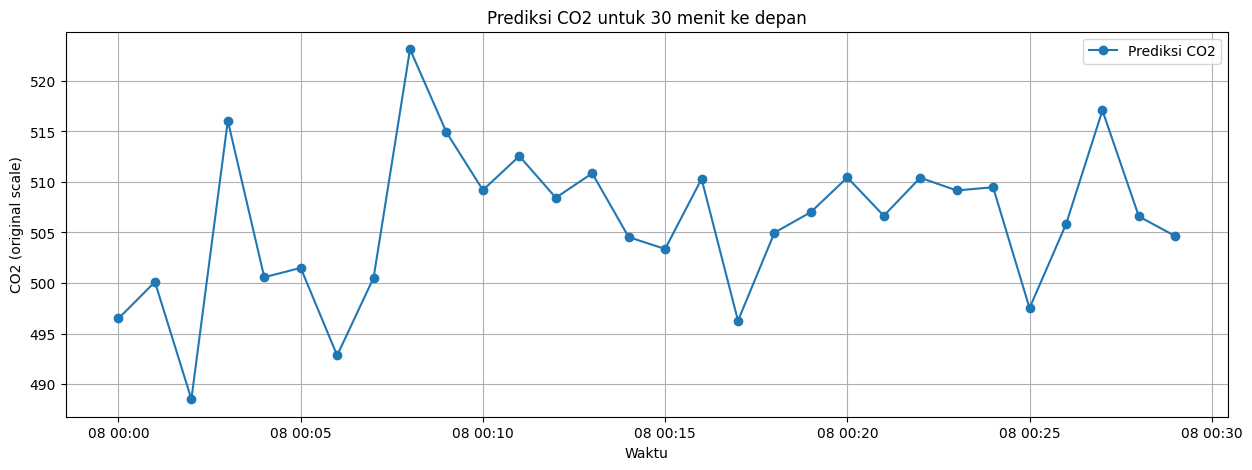

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt


# --- 1. Load scaler yang sudah disimpan ---
scaler = joblib.load('scaler.save')  # Ganti dengan nama file kamu kalau beda
cols_to_scale = ['co2', 'temperature', 'humidity', 'rainfall', 'pyrano']

# --- 2. Ambil data terakhir sebanyak n_past time step ---
n_past = 1440
n_future = 30
N_FEATURES = 4

# Ambil fitur saja dari df_scaled (harus sudah ada)
recent_data = df_scaled[['temperature', 'humidity', 'rainfall', 'pyrano']].values[-n_past:]

# Pastikan shape = (1, n_past, N_FEATURES)
input_for_model = recent_data.reshape(1, n_past, N_FEATURES)

# --- 3. Prediksi menggunakan model LSTM yang sudah dilatih ---
predicted_scaled = model.predict(input_for_model)

# --- 4. Inverse transform hasil prediksi ---
# Kita buat array dummy agar bisa inverse_transform
dummy_full = np.zeros((predicted_scaled.shape[1], len(cols_to_scale)))  # shape: (30, 5)
dummy_full[:, cols_to_scale.index('co2')] = predicted_scaled[0]

predicted_original = scaler.inverse_transform(dummy_full)[:, cols_to_scale.index('co2')]

# --- 5. Buat timestamp untuk 30 langkah ke depan ---
last_timestamp = pd.to_datetime(df_scaled['timestamp'].iloc[-1])
future_timestamps = [last_timestamp + pd.Timedelta(minutes=1) * i for i in range(1, n_future + 1)]

# --- 6. Visualisasi hasil prediksi ---
plt.figure(figsize=(15, 5))
plt.plot(future_timestamps, predicted_original, marker='o', label='Prediksi CO2')
plt.title('Prediksi CO2 untuk 30 menit ke depan')
plt.xlabel('Waktu')
plt.ylabel('CO2 (original scale)')
plt.legend()
plt.grid(True)
plt.show()


## **INFERENCE DATA BARU (DUMMY)**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

# 1. Load data baru
df = pd.read_csv('/content/data_dummy_lingkungan.csv', parse_dates=['timestamp'])
df = df[['timestamp', 'co2', 'temperature', 'humidity', 'rainfall', 'pyrano']]

In [ ]:
# 2. Isi missing value
df_filled = df.ffill().bfill()
df_filled = df_filled.sort_values(by='timestamp').reset_index(drop=True)


In [ ]:
# 3. Load scaler dan model
scaler = joblib.load('scaler.save')
model = tf.keras.models.load_model('/content/my_model.h5', compile=False)

In [ ]:
# 4. Scaling
cols_to_scale = ['co2', 'temperature', 'humidity', 'rainfall', 'pyrano']
df_scaled = df_filled.copy()
df_scaled[cols_to_scale] = scaler.transform(df_scaled[cols_to_scale])


In [ ]:
# 5. Ambil data input model
n_past = 1440
n_future = 30
N_FEATURES = 4

recent_data = df_scaled[['temperature', 'humidity', 'rainfall', 'pyrano']].values[-n_past:]
input_for_model = recent_data.reshape(1, n_past, N_FEATURES)


In [ ]:
# 6. Prediksi
predicted_scaled = model.predict(input_for_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# 7. Inverse transform prediksi
dummy_full = np.zeros((n_future, len(cols_to_scale)))
dummy_full[:, cols_to_scale.index('co2')] = predicted_scaled[0]

predicted_original = scaler.inverse_transform(dummy_full)[:, cols_to_scale.index('co2')]

In [ ]:
# 8. Buat timestamp prediksi
last_timestamp = df_scaled['timestamp'].iloc[-1]
future_timestamps = [last_timestamp + pd.Timedelta(minutes=i) for i in range(1, n_future + 1)]


In [ ]:
# 9. Hasil akhir
df_prediksi = pd.DataFrame({
    'timestamp': future_timestamps,
    'prediksi_co2': predicted_original
})

# 10. Tampilkan hasil
print(df_prediksi)


             timestamp  prediksi_co2
0  2025-06-11 00:00:00    387.936825
1  2025-06-11 00:01:00    385.384998
2  2025-06-11 00:02:00    386.576549
3  2025-06-11 00:03:00    385.060907
4  2025-06-11 00:04:00    387.227439
5  2025-06-11 00:05:00    387.854468
6  2025-06-11 00:06:00    386.644315
7  2025-06-11 00:07:00    387.787642
8  2025-06-11 00:08:00    387.150264
9  2025-06-11 00:09:00    387.105636
10 2025-06-11 00:10:00    386.984295
11 2025-06-11 00:11:00    388.613947
12 2025-06-11 00:12:00    387.375319
13 2025-06-11 00:13:00    387.022662
14 2025-06-11 00:14:00    387.376772
15 2025-06-11 00:15:00    385.979340
16 2025-06-11 00:16:00    385.662450
17 2025-06-11 00:17:00    387.555957
18 2025-06-11 00:18:00    385.782251
19 2025-06-11 00:19:00    386.216637
20 2025-06-11 00:20:00    388.072490
21 2025-06-11 00:21:00    385.330322
22 2025-06-11 00:22:00    384.183409
23 2025-06-11 00:23:00    384.985652
24 2025-06-11 00:24:00    385.568723
25 2025-06-11 00:25:00    387.066366
2